In [2]:
pip install fuzzywuzzy

In [4]:
from fuzzywuzzy import fuzz
from collections import Counter

# Sample dataset of column name variations
column_variations = [
    "ACC_NUMBER", "ACCNBR", "ACC_NBR", "ACNMBR",
    "ACCOUNT_NUMBER", "ACCNT_NMBR", "ACCNT_NBR"
]

# Function to predict the standard column name from a new variation
def predict_column_name(new_column_name, column_variations):
    # Calculate the similarity of the new column name to the existing ones
    similarities = [(col, fuzz.ratio(new_column_name, col)) for col in column_variations]

    # Sort the columns by similarity score (higher score means more similar)
    similarities.sort(key=lambda x: x[1], reverse=True)

    # Get the most similar column name (typically the first one after sorting)
    predicted_name = similarities[0][0]

    return predicted_name

# Example: Predict for the new column name 'ACCNTNMBR'
new_column_name = "AC_BR"
predicted_name = predict_column_name(new_column_name, column_variations)

print(f"Predicted column name for '{new_column_name}': {predicted_name}")


Predicted column name for 'AC_BR': ACC_NBR


In [11]:
pip install scikit-learn fuzzywuzzy


**Using Fuzzy algorithm**

In [21]:
import pandas as pd
from fuzzywuzzy import fuzz

# Define the dataset of column name variations and their corresponding standard names
column_variations = [
    'CUST_NO', 'OBL_CODE', 'ACCT_NBR',
    'CUST_TYPE',
    'ACCOUNT_NUMBER', 'ACCNT_NMBR', 'ACCNT_NBR',
    'CUS_NAME', 'CUSTOMER_NAME', 'CLIENT_NAME',
    'PHN', 'PHONE_NUMBER', 'CONTACT_NUMBER',
    'DOB', 'DATE_OF_BIRTH', 'BIRTHDATE',
    'ADDR', 'ADDRESS', 'STREET_ADDRESS'
]

standard_names = [
    'PERS_ID', 'PERS_ID', 'PERS_ID',
    'ID_SUB_CTG',
    'Account Number', 'Account Number', 'Account Number',
    'Customer Name', 'Customer Name', 'Customer Name',
    'Phone Number', 'Phone Number', 'Phone Number',
    'Date of Birth', 'Date of Birth', 'Date of Birth',
    'Street Address', 'Street Address', 'Street Address'
]

# Define new column name variations for prediction
new_column_names = [
    'ac_br', 'd_birth', 'con_nmbr', 'CU_NO',
    'CUST_TYPE', 'CUSTYPE', 'CTYPE'
    ]

# A dictionary to map common abbreviations to their full names
abbreviation_map = {
    'ac_br': 'Account Number',
    'd_birth': 'Date of Birth',
    'con_nmbr': 'Phone Number',
    'add_r': 'Street Address',
    # Add more mappings here as necessary
}

# Function to predict the standard column name using fuzzy matching or abbreviation map
def predict_column_name(new_name, column_variations, standard_names, abbreviation_map):
    # Check if the new name is in the abbreviation map
    if new_name in abbreviation_map:
        return abbreviation_map[new_name]

    # Use fuzzy matching to compare the new name with all column variations
    similarities = [(var, fuzz.ratio(new_name, var)) for var in column_variations]
    # Sort by similarity score in descending order
    similarities.sort(key=lambda x: x[1], reverse=True)

    # Check for threshold similarity (to avoid incorrect matches)
    threshold = 60  # Lowered threshold for better matching
    if similarities[0][1] < threshold:
        return "Unknown"  # If the match is not strong enough, return "Unknown"

    # Return the standard name corresponding to the highest similarity match
    max_similarity_idx = column_variations.index(similarities[0][0])
    return standard_names[max_similarity_idx]

# Function to predict the SQL data type based on the column name
def predict_data_type(column_name):
    # Map column names to SQL data types
    column_name = column_name.lower()

    if 'account' in column_name or 'phn' in column_name or 'number' in column_name:
        return 'VARCHAR(255)'  # Account Number, Phone Number, etc. are typically VARCHAR
    elif 'date' in column_name or 'dob' in column_name:
        return 'DATE'  # Date fields like Date of Birth are DATE
    elif 'address' in column_name or 'street' in column_name:
        return 'VARCHAR(255)'  # Address fields are VARCHAR
    else:
        return 'TEXT'  # Default to TEXT if no specific pattern is found

# Predict standard column names and their corresponding data types for the new variations
predicted_column_names_and_types = []
for new_column in new_column_names:
    predicted_name = predict_column_name(new_column, column_variations, standard_names, abbreviation_map)

    # If "Unknown" is returned, handle this case.
    if predicted_name == "Unknown":
        print(f"Warning: Unable to predict a standard name for column '{new_column}'.")
        predicted_type = 'TEXT'  # Default to TEXT type if not recognized
    else:
        predicted_type = predict_data_type(predicted_name)

    predicted_column_names_and_types.append((predicted_name, predicted_type))

# SQL CREATE TABLE generation based on predicted column names and types
def generate_create_table_query(predicted_column_names_and_types, table_name):
    sql_query = f"CREATE TABLE {table_name} (\n"

    for col_name, col_type in predicted_column_names_and_types:
        # Convert column name to lowercase with underscores (standard SQL style)
        sql_query += f"    {col_name.replace(' ', '_').lower()} {col_type} NOT NULL,\n"

    # Remove the trailing comma for the last column
    sql_query = sql_query.rstrip(',\n') + "\n);"

    return sql_query

# Generate the SQL CREATE TABLE query based on the predicted column names and types
table_name = "predicted_table"
create_table_query = generate_create_table_query(predicted_column_names_and_types, table_name)

# Output the predicted column names, data types, and the SQL query
print("Predicted Column Names and Types:")
for col_name, col_type in predicted_column_names_and_types:
    print(f"{col_name}: {col_type}")

print("\nGenerated SQL CREATE TABLE Query:")
print(create_table_query)


Predicted Column Names and Types:
Account Number: VARCHAR(255)
Date of Birth: DATE
Phone Number: VARCHAR(255)
PERS_ID: TEXT
ID_SUB_CTG: TEXT
ID_SUB_CTG: TEXT
ID_SUB_CTG: TEXT

Generated SQL CREATE TABLE Query:
CREATE TABLE predicted_table (
    account_number VARCHAR(255) NOT NULL,
    date_of_birth DATE NOT NULL,
    phone_number VARCHAR(255) NOT NULL,
    pers_id TEXT NOT NULL,
    id_sub_ctg TEXT NOT NULL,
    id_sub_ctg TEXT NOT NULL,
    id_sub_ctg TEXT NOT NULL
);


**Using Random Forest**

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

# Define the dataset of column name variations and their corresponding standard names
column_variations = [
    'ACC_NUMBER', 'ACCNBR', 'ACC_NBR', 'ACNMBR',
    'ACCOUNT_NUMBER', 'ACCNT_NMBR', 'ACCNT_NBR',
    'CUS_NAME', 'CUSTOMER_NAME', 'CLIENT_NAME',
    'PHN', 'PHONE_NUMBER', 'CONTACT_NUMBER',
    'DOB', 'DATE_OF_BIRTH', 'BIRTHDATE',
    'ADDR', 'ADDRESS', 'STREET_ADDRESS'
]

standard_names = [
    'Account Number', 'Account Number', 'Account Number', 'Account Number',
    'Account Number', 'Account Number', 'Account Number',
    'Customer Name', 'Customer Name', 'Customer Name',
    'Phone Number', 'Phone Number', 'Phone Number',
    'Date of Birth', 'Date of Birth', 'Date of Birth',
    'Street Address', 'Street Address', 'Street Address'
]

# Define new column name variations for prediction
new_column_names = ['ac_br', 'd_birth', 'con_nmbr']

# Create a DataFrame from the column variations and their corresponding standard names
data = pd.DataFrame({
    'column_variation': column_variations,
    'standard_name': standard_names
})

# Split the dataset into features (X) and target (y)
X = data['column_variation']
y = data['standard_name']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline that first transforms the text data and then applies a classifier
model = make_pipeline(
    TfidfVectorizer(),  # Converts column names into numerical features
    RandomForestClassifier(n_estimators=100, random_state=42)  # Random Forest Classifier
)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Now, let's use the trained model to predict new column names
predicted_names = model.predict(new_column_names)

# Function to predict SQL data type based on the column name
def predict_data_type(column_name):
    column_name = column_name.lower()

    if 'account' in column_name or 'phn' in column_name or 'number' in column_name:
        return 'VARCHAR(255)'  # Account Number, Phone Number, etc. are typically VARCHAR
    elif 'date' in column_name or 'dob' in column_name:
        return 'DATE'  # Date fields like Date of Birth are DATE
    elif 'address' in column_name or 'street' in column_name:
        return 'VARCHAR(255)'  # Address fields are VARCHAR
    else:
        return 'TEXT'  # Default to TEXT if no specific pattern is found

# Predict standard names and data types for new column variations
predicted_column_names_and_types = []
for new_column, predicted_name in zip(new_column_names, predicted_names):
    predicted_type = predict_data_type(predicted_name)
    predicted_column_names_and_types.append((predicted_name, predicted_type))

# SQL CREATE TABLE generation based on predicted column names and types
def generate_create_table_query(predicted_column_names_and_types, table_name):
    sql_query = f"CREATE TABLE {table_name} (\n"

    for col_name, col_type in predicted_column_names_and_types:
        # Convert column name to lowercase with underscores (standard SQL style)
        sql_query += f"    {col_name.replace(' ', '_').lower()} {col_type} NOT NULL,\n"

    # Remove the trailing comma for the last column
    sql_query = sql_query.rstrip(',\n') + "\n);"

    return sql_query

# Generate the SQL CREATE TABLE query based on the predicted column names and types
table_name = "predicted_table"
create_table_query = generate_create_table_query(predicted_column_names_and_types, table_name)

# Output the predicted column names, data types, and the SQL query
print("\nPredicted Column Names and Types:")
for col_name, col_type in predicted_column_names_and_types:
    print(f"{col_name}: {col_type}")

print("\nGenerated SQL CREATE TABLE Query:")
print(create_table_query)


Model Accuracy: 60.00%

Predicted Column Names and Types:
Account Number: VARCHAR(255)
Account Number: VARCHAR(255)
Account Number: VARCHAR(255)

Generated SQL CREATE TABLE Query:
CREATE TABLE predicted_table (
    account_number VARCHAR(255) NOT NULL,
    account_number VARCHAR(255) NOT NULL,
    account_number VARCHAR(255) NOT NULL
);


**Random Forest without Training**

In [16]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

# Define the dataset of column name variations and their corresponding standard names
column_variations = [
    'CUST_NO', 'OBL_CODE', 'ACCT_NBR',
    'CUST_TYPE',
    'ACC_NUMBER', 'ACCNBR', 'ACC_NBR', 'ACNMBR',
    'ACCOUNT_NUMBER', 'ACCNT_NMBR', 'ACCNT_NBR',
    'CUS_NAME', 'CUSTOMER_NAME', 'CLIENT_NAME',
    'PHN', 'PHONE_NUMBER', 'CONTACT_NUMBER',
    'DOB', 'DATE_OF_BIRTH', 'BIRTHDATE',
    'ADDR', 'ADDRESS', 'STREET_ADDRESS',
    'AC_BR', 'D_BIRTH', 'CON_NMBR'  # Additional variations added for the new prediction
]

standard_names = [
    'PERS_ID', 'PERS_ID', 'PERS_ID',
    'ID_SUB_CTG',
    'Account Number', 'Account Number', 'Account Number', 'Account Number',
    'Account Number', 'Account Number', 'Account Number',
    'Customer Name', 'Customer Name', 'Customer Name',
    'Phone Number', 'Phone Number', 'Phone Number',
    'Date of Birth', 'Date of Birth', 'Date of Birth',
    'Street Address', 'Street Address', 'Street Address',
    'Account Number', 'Date of Birth', 'Phone Number'  # These correspond to the new variations
]

# Define new column name variations for prediction
new_column_names = ['ac_br', 'd_birth', 'con_nmbr', 'OBL_CODE']

# Create a DataFrame from the column variations and their corresponding standard names
data = pd.DataFrame({
    'column_variation': column_variations,
    'standard_name': standard_names
})

# Create a pipeline that first transforms the text data and then applies a classifier
model = make_pipeline(
    TfidfVectorizer(),  # Converts column names into numerical features
    RandomForestClassifier(n_estimators=100, random_state=42)  # Random Forest Classifier
)

# Train the model on all the available data
model.fit(data['column_variation'], data['standard_name'])

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

# Now, let's use the trained model to predict new column names
predicted_names = model.predict(new_column_names)

# Function to predict SQL data type based on the column name
def predict_data_type(column_name):
    column_name = column_name.lower()

    if 'account' in column_name or 'phn' in column_name or 'number' in column_name:
        return 'VARCHAR(255)'  # Account Number, Phone Number, etc. are typically VARCHAR
    elif 'date' in column_name or 'dob' in column_name:
        return 'DATE'  # Date fields like Date of Birth are DATE
    elif 'address' in column_name or 'street' in column_name:
        return 'VARCHAR(255)'  # Address fields are VARCHAR
    else:
        return 'TEXT'  # Default to TEXT if no specific pattern is found

# Predict standard names and data types for new column variations
predicted_column_names_and_types = []
for new_column, predicted_name in zip(new_column_names, predicted_names):
    predicted_type = predict_data_type(predicted_name)
    predicted_column_names_and_types.append((predicted_name, predicted_type))

# SQL CREATE TABLE generation based on predicted column names and types
def generate_create_table_query(predicted_column_names_and_types, table_name):
    sql_query = f"CREATE TABLE {table_name} (\n"

    for col_name, col_type in predicted_column_names_and_types:
        # Convert column name to lowercase with underscores (standard SQL style)
        sql_query += f"    {col_name.replace(' ', '_').lower()} {col_type} NOT NULL,\n"

    # Remove the trailing comma for the last column
    sql_query = sql_query.rstrip(',\n') + "\n);"

    return sql_query

# Generate the SQL CREATE TABLE query based on the predicted column names and types
table_name = "predicted_table"
create_table_query = generate_create_table_query(predicted_column_names_and_types, table_name)

# Output the predicted column names, data types, and the SQL query
print("\nPredicted Column Names and Types:")
for col_name, col_type in predicted_column_names_and_types:
    print(f"{col_name}: {col_type}")

print("\nGenerated SQL CREATE TABLE Query:")
print(create_table_query)


Model Accuracy: 60.00%


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

Show Diagram Feature

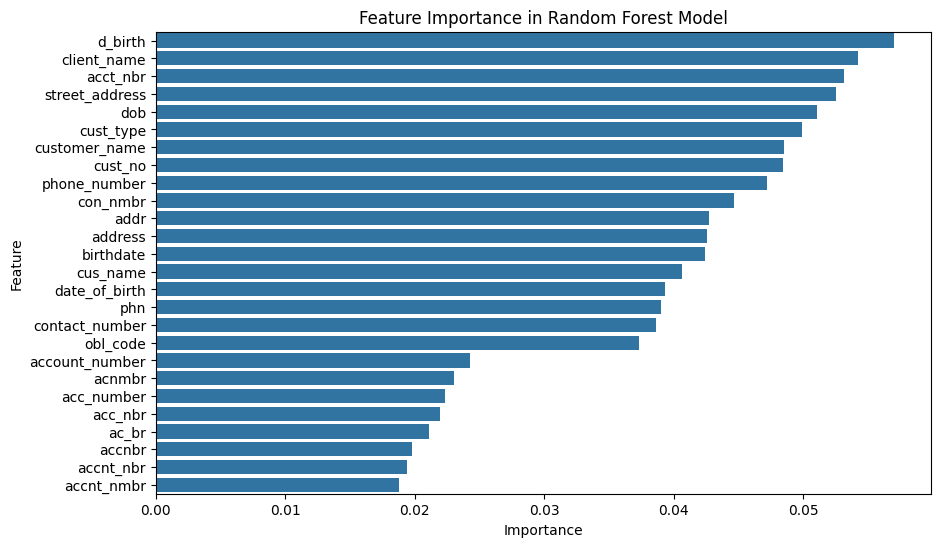

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the feature importances from the trained model
importances = model.named_steps['randomforestclassifier'].feature_importances_

# Get the feature names from the TF-IDF vectorizer (vocabulary)
vectorizer = model.named_steps['tfidfvectorizer']
feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame for feature importances and their corresponding feature names
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance in Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Show Diagram Tree

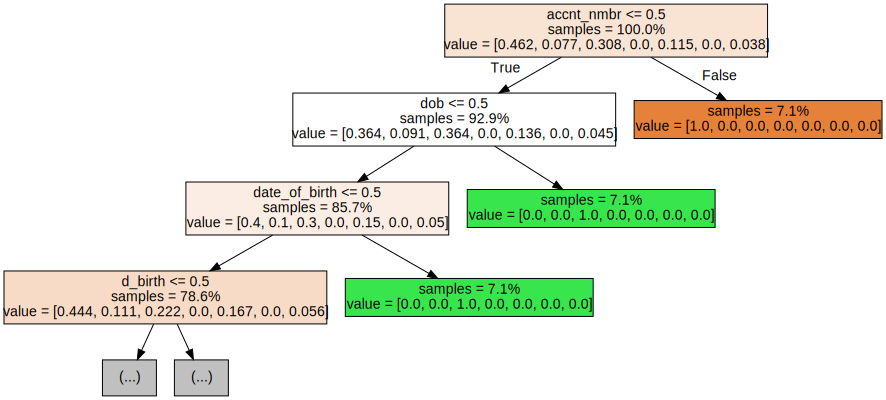

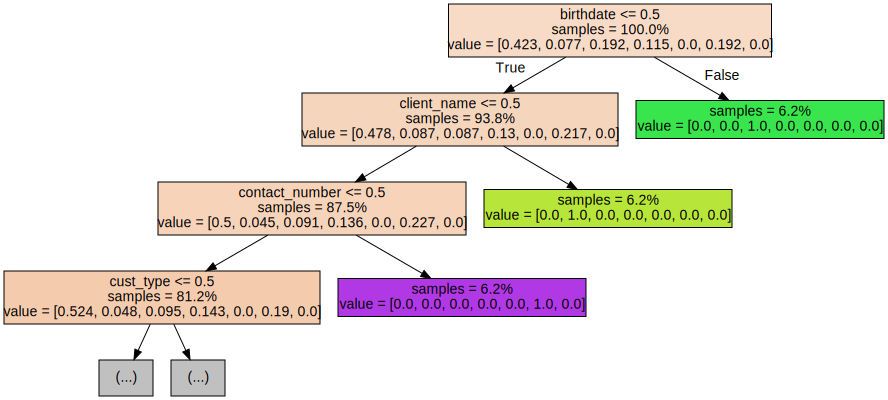

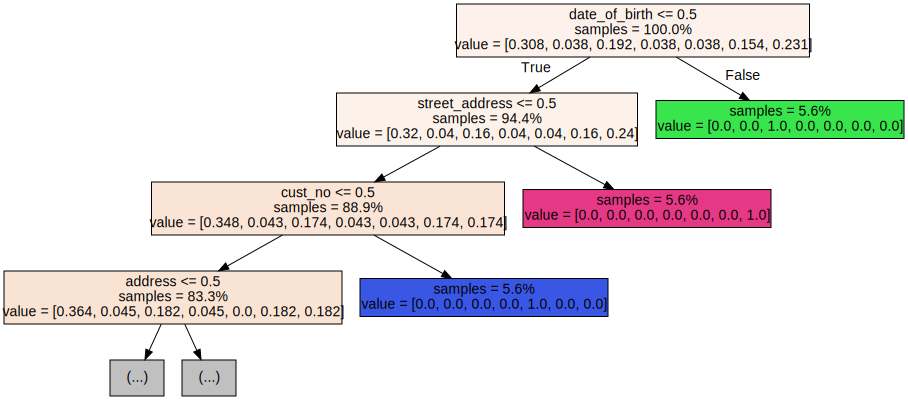

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
import graphviz

# Get the trained Random Forest model
rf_model = model.named_steps['randomforestclassifier']

# Loop through the first 3 trees in the Random Forest and visualize them
for i in range(3):  # You can change this number to visualize more trees
    tree = rf_model.estimators_[i]

    # Export tree to DOT format
    dot_data = export_graphviz(tree,
                               feature_names=model.named_steps['tfidfvectorizer'].get_feature_names_out(),
                               filled=True,
                               max_depth=3,  # Limit the depth of the tree for better readability
                               impurity=False,
                               proportion=True)

    # Generate and display the tree graph
    graph = graphviz.Source(dot_data)
    graph.render(f"tree_{i}.pdf", view=True)  # Optionally save the graph as a PDF and open it
    display(graph)  # Display the graph inline (works in Jupyter Notebook)